In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TimeSeriesData():
    def __init__(self, num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        self.x_data = np.linspace(xmin , xmax , num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self , x_series):
        return np.sin(x_series)
    def next_batch(self , batch_size , steps , return_batch_ts = False):
        #Grab random start points
        rand_start = np.random.rand(batch_size,1)
        
        #Since starting points may not be a part of curve, make it a part of the curve
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        #Create batch time series on X-axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        #Take sine of X-values
        y_batch = np.sin(batch_ts)
        
        if return_batch_ts:
            return y_batch[ : , :-1 ].reshape(-1,steps,1) , y_batch[ : , 1:].reshape(-1,steps,1) , batch_ts
        else:
            return y_batch[ : , :-1 ].reshape(-1,steps,1) , y_batch[ : , 1:].reshape(-1,steps,1)
        

In [3]:
ts_data = TimeSeriesData(250 , 0 ,10)

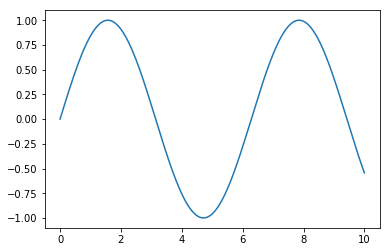

In [4]:
plt.plot(ts_data.x_data , ts_data.y_true)

In [5]:
time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1 ,time_steps , True)

In [7]:
ts.shape

(1, 31)

In [8]:
ts.flatten()

array([0.53798451, 0.57798451, 0.61798451, 0.65798451, 0.69798451,
       0.73798451, 0.77798451, 0.81798451, 0.85798451, 0.89798451,
       0.93798451, 0.97798451, 1.01798451, 1.05798451, 1.09798451,
       1.13798451, 1.17798451, 1.21798451, 1.25798451, 1.29798451,
       1.33798451, 1.37798451, 1.41798451, 1.45798451, 1.49798451,
       1.53798451, 1.57798451, 1.61798451, 1.65798451, 1.69798451,
       1.73798451])

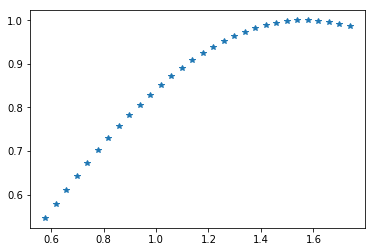

In [9]:
plt.plot(ts.flatten()[1:] , y2.flatten(), '*')

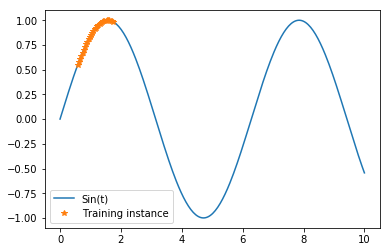

In [10]:
plt.plot(ts_data.x_data , ts_data.y_true,label = 'Sin(t)')
plt.plot(ts.flatten()[1:] , y2.flatten(), '*' , label = 'Training instance')
plt.legend()

In [11]:
#TRAINING DATA

train_inst = np.linspace(5 , 5 + ts_data.resolution*(time_steps + 1) , time_steps + 1)
train_inst


array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

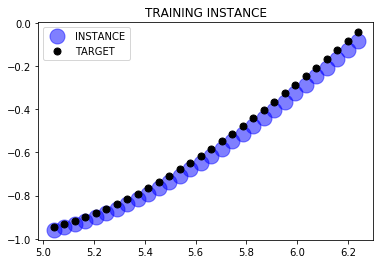

In [12]:
plt.title('TRAINING INSTANCE')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[:-1]) ,'bo' , markersize=15,alpha = 0.5 , label = 'INSTANCE')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]) ,'ko' , markersize=7,label = 'TARGET')
plt.legend()

# MODEL

In [14]:
tf.reset_default_graph()

In [16]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_iterations = 2000
batch_size = 1

In [17]:
X = tf.placeholder(tf.float32 , [ None , time_steps, num_inputs])
y = tf.placeholder(tf.float32 , [ None , time_steps, num_inputs])

In [18]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units = num_neurons, activation = tf.nn.relu), output_size = num_outputs)

In [20]:
outputs , states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [21]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = optimizer.minimize(loss)


In [22]:
init = tf.global_variables_initializer()

In [23]:
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.7) #GPU ONLY 
saver = tf.train.Saver()


In [28]:
#with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess: #GPU ONLY
with tf.Session() as sess:
    sess.run(init)
    for it in range(num_iterations):
        X_batch , y_batch = ts_data.next_batch(batch_size,time_steps)
        sess.run(train , feed_dict = {X:X_batch , y:y_batch})
        
        
        if it%100 == 0:
            mse = loss.eval(feed_dict = {X:X_batch , y:y_batch})
            print(it , "\tMSE = " , mse)
            
    saver.save(sess , './RNNCodeAlong')

0 	MSE =  1.2445775
100 	MSE =  0.21647215
200 	MSE =  0.19231172
300 	MSE =  0.031867202
400 	MSE =  0.03490867
500 	MSE =  0.012354186
600 	MSE =  0.010631322
700 	MSE =  0.019543162
800 	MSE =  0.0029590433
900 	MSE =  0.002603088
1000 	MSE =  0.007587473
1100 	MSE =  0.0071474095
1200 	MSE =  0.012338396
1300 	MSE =  0.020697989
1400 	MSE =  0.0047226413
1500 	MSE =  9.300722e-05
1600 	MSE =  0.009394613
1700 	MSE =  0.020277832
1800 	MSE =  0.0007182045
1900 	MSE =  0.007079213


In [29]:
with tf.Session() as sess:
    saver.restore(sess , './RNNCodeAlong')
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1 , time_steps,num_inputs)))
    y_pred = sess.run(outputs , feed_dict = {X : X_new})

INFO:tensorflow:Restoring parameters from ./RNNCodeAlong


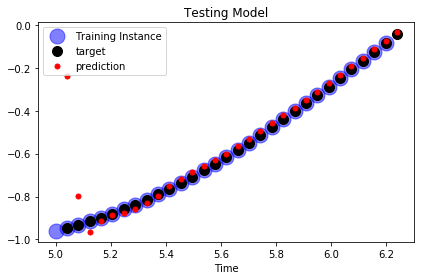

In [30]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()